<a href="https://colab.research.google.com/github/parth-gulati/CMPT-732/blob/main/8_Point_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: data/mount_rushmore_1.jpg  
  inflating: data/mount_rushmore_2.jpg  
  inflating: data/myleft.jpg         
  inflating: data/myright.jpg        
  inflating: data/notredam_1.jpg     
  inflating: data/notredam2.jpg      


In [ ]:
def find_matching_keypoints(image1, image2):
    #Input: two images (numpy arrays)
    #Output: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)

    good = []
    pts1 = []
    pts2 = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.8 * n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return pts1, pts2

In [ ]:
def drawlines(img1,img2,lines,pts1,pts2):
    #img1: image on which we draw the epilines for the points in img2
    #lines: corresponding epilines
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [ ]:
def FindFundamentalMatrix(pts1, pts2):
    #Input: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    #Output: fundamental matrix (numpy array of shape (3, 3))
    N = pts1.shape[0]
    #todo: Normalize the points
    centroid_1 = np.array([np.mean((pts1), axis=0)]).squeeze(0)
    centroid_2 = np.array([np.mean((pts2), axis=0)]).squeeze(0)

    newPts1 = np.zeros((N, 2))

    newPts1[0] = pts1[0] - centroid_1[0]
    newPts1[1] = pts1[1] - centroid_1[1]

    newPts2 = np.zeros((N ,2))
    newPts2[0] = pts2[0] - centroid_2[0]
    newPts2[1] = pts2[1] - centroid_2[1]
    
    distances_1 = [[x**2, y**2] for (x, y) in newPts1]
    mean_distance_1 = np.mean(distances_1)

    distances_2 = [[x**2, y**2] for (x, y) in newPts2]
    mean_distance_2 = np.mean(distances_2)
    
    scale_1 = np.sqrt(2) / mean_distance_1
    scale_2 = np.sqrt(2) / mean_distance_2

    T1 = np.eye(3)
    T2 = np.eye(3)

    T1[0][0] = scale_1
    T1[1][1] = scale_1
    T1[0][2] = -scale_1 * centroid_1[0]
    T1[0][0] = scale_1 * centroid_1[1]

    T2[0][0] = scale_2
    T2[1][1] = scale_2
    T2[0][2] = -scale_2 * centroid_2[0]
    T2[0][0] = scale_2 * centroid_2[1]

    newPts1 = np.array([T1 @ [x, y, 1] for (x, y) in pts1])
    newPts2 = np.array([T2 @ [x, y, 1] for (x, y) in pts2])

    #todo: Form the matrix A
    A = np.array([[v2[0]*v1[0], v2[0]*v1[1], v2[0], v2[1]*v1[0], v2[1] * v1[1], v2[1], v1[0], v1[1], 1] for (v1, v2) in zip(newPts1, newPts2)])

    V = np.linalg.svd(A)[2]
    F = V.T[:, 8]
    F = np.reshape(F, (3,3))

    F = np.dot(np.dot(T2.T, F), T1)

    return F

    #todo: Find the fundamental matrix
    

In [ ]:
def FindFundamentalMatrixRansac(pts1, pts2, num_trials = 1000, threshold = 0.01):
    #Input: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    #Output: fundamental matrix (numpy array of shape (3, 3))
    N = pts1.shape[0]

    max_matches = -1
    best_F = np.zeros((3,3))

    for k in range(num_trials):
      random_indices = np.random.choice(N, 8)

      p1 = np.array([pts1[i] for i in random_indices])
      p2 = np.array([pts2[i] for i in random_indices])
      
      F = FindFundamentalMatrix(p1, p2)

      inliers = 0

      x1 = np.array([[x, y, 1] for (x,y) in pts1])
      x2 = np.array([[x, y, 1] for (x,y) in pts2])
        
      for i in range(N):
        if x2[i].T.dot(F).dot(x1[i]) < threshold:
          inliers+=1
      
      if inliers > max_matches:
        best_F = F
        ideal_indices = random_indices
    
    return best_F


    #todo: Run RANSAC and find the best fundamental matrix

0.9489824494716966


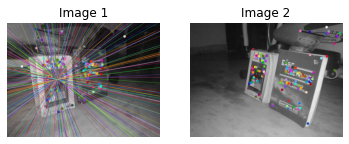

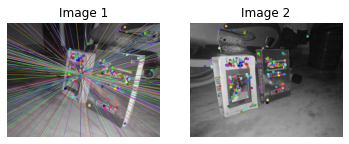

In [ ]:
data_path = './data'
use_ransac = True

#Load images
image1_path = os.path.join(data_path, 'myleft.jpg')
image2_path = os.path.join(data_path, 'myright.jpg')
image1 = np.array(Image.open(image1_path).convert('L'))
image2 = np.array(Image.open(image2_path).convert('L'))


#Find matching keypoints
pts1, pts2 = find_matching_keypoints(image1, image2)

#Builtin opencv function for comparison
F_true = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)[0]

#todo: FindFundamentalMatrix
if use_ransac:
    F = FindFundamentalMatrixRansac(pts1, pts2)
else:
    F = FindFundamentalMatrix(pts1, pts2)

error = np.linalg.norm(F-F_true)
print(error)

# Find epilines corresponding to points in second image,  and draw the lines on first image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()